In [1]:
%load_ext autoreload
%autoreload 2
import keras

Using TensorFlow backend.


In [2]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, InputLayer
from keras.layers.convolutional import Conv2D, MaxPooling2D
import sys
import os
pwd = os.getcwd()
sys.path.append("/root/Gan/jidian/MLexperiments")
sys.path.append("/root/Gan/jidian")
sys.path.append(pwd)
sys.path.append(os.path.dirname(os.getcwd()))
import MLexperiments.classes
from MLexperiments.classes import ReadAutoLabeledData
import tensorflow as tf
import MLexperiments.config.parameters
from keras.layers import LSTM, Reshape
import matplotlib.pyplot as plt
import utils
from keras.callbacks import ModelCheckpoint
import os
from keras.callbacks import TensorBoard
from time import time
from keras.models import Model
from keras.layers import Input, Dense
import datetime
import Models
import os, errno


In [ ]:
#+12h = chinese time zone


#
tf.flags.DEFINE_integer("BATCH_SIZE",128, "size")
tf.flags.DEFINE_integer("MODEL_TYPE",0 , "0: CNN, 1:RNN")
tf.flags.DEFINE_string("CHECKPOINTPATH",'logs/{}'.format(datetime.datetime.fromtimestamp(time()).strftime('%Y-%m-%d %H:%M:%S'))\
                       , "Path to save the best models")
tf.flags.DEFINE_string("MODE",  3\
                       , " mode is data source specification;   mode: 1 => 3 human + rain: 1 means high only, 2 high + mid, 3 high+mid+low ,4=>6 man + rain + wind:      4 means high only, 5 high + mid, 6 high+mid+low , 7 => qinshang + factory for testing")

FLAGS = tf.flags.FLAGS
FLAGS._parse_flags()

In [3]:
FLAGS.CHECKPOINTPATH = FLAGS.CHECKPOINTPATH + "for what use"
SAVE_BEST_ONLY = False
FLAGS.MODE = 3

['-f', '/run/user/0/jupyter/kernel-5cb5ec4f-cfa2-4247-ba4d-1806cbb91cd8.json']

In [4]:
#data reading and initialization

try:
    os.makedirs(FLAGS.CHECKPOINTPATH)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise


In [5]:
myDataSet = utils.read_data_sets(one_hot=True, test_size = 0.1, validation_size = 0.1, fake_data = False\
                                , mode = FLAGS.MODE
                                )

(X_train, y_train), (X_test, y_test) , (X_Ftest, y_Ftest)= (myDataSet.train.images, myDataSet.train.labels), (myDataSet.validation.images, myDataSet.validation.labels), (myDataSet.test.images, myDataSet.test.labels)

print(X_train[0].shape)
print(y_train[0])

X_train = X_train.reshape(X_train.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')
X_Ftest = X_Ftest.reshape(X_Ftest.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')

#X_train /= 255
#X_test /= 255


def tran_y(y):
    y_ohe = np.zeros(MLexperiments.config.parameters.OUTPUTNUM)
    
    y_ohe[int(y)] = 1 
    return y_ohe

# def tran_y(y):
#     y_ohe = np.zeros(MLexperiments.config.parameters.OUTPUTNUM)
#     if y:
#         y_ohe[1] = 1
#     else:
#         y_ohe[0] = 1
#     return y_ohe
# def tran_y(y):
#     return y
#import pdb;pdb.set_trace()
y_train_ohe = np.array([tran_y(y_train[i]) for i in range(len(y_train))])
y_test_ohe = np.array([tran_y(y_test[i]) for i in range(len(y_test))])

y_Ftest_ohe = np.array([tran_y(y_Ftest[i]) for i in range(len(y_Ftest))])

loading mode = 3(default)
number of each type (balanced):
49473
total (balanced):
98946
 np_input shape:  (98946, 100, 10) labelData shape:  (98946,)
read succesful
(1000,)
1.0


In [8]:
model = Models.getMODEL(FLAGS.MODEL_TYPE)

#model.load_weights("/root/Gan/jidian/MLexperiments/scripts/logs/2017-10-30 03:36:13/best_weights.hdf5")
model.load_weights("best_weights.hdf5", by_name=True)
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

#model.load_weights("/root/Gan/jidian/MLexperiments/scripts/logs/2017-10-30 03:36:13/best_weights.hdf5")
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
        self.is_start = True
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
    def on_train_begin(self, logs={}):
        if self.is_start:
            self.losses = []
            self.val_losses = []
            self.acc = []
            self.val_acc = []
            self.is_start = False
            
            

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
lossHistory = LossHistory()
checkpointer = ModelCheckpoint(filepath = os.path.join(FLAGS.CHECKPOINTPATH, 'best_weights.hdf5'), verbose=1, save_best_only=SAVE_BEST_ONLY)
tensorboard = TensorBoard(log_dir=FLAGS.CHECKPOINTPATH,histogram_freq=0, batch_size=FLAGS.BATCH_SIZE, write_graph=True, write_grads=False, \
                          write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

model.summary()
#



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 98, 8, 64)         640       
_________________________________________________________________
batch_normalization_11 (Batc (None, 98, 8, 64)         256       
_________________________________________________________________
dropout_17 (Dropout)         (None, 98, 8, 64)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 96, 6, 128)        73856     
_________________________________________________________________
batch_normalization_12 (Batc (None, 96, 6, 128)        512       
_________________________________________________________________
dropout_18 (Dropout)         (None, 96, 6, 128)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 6, 32)         4128      
__________

In [9]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5,6"

history = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=100, batch_size=FLAGS.BATCH_SIZE, \
                callbacks=[\
                           lossHistory,\
                           checkpointer,\
                           tensorboard\
                          ] )

Train on 80146 samples, validate on 8905 samples
Epoch 1/100
80146/80146 [==============================] - 29s - loss: 0.2893 - acc: 0.8955 - val_loss: 0.2193 - val_acc: 0.9288
Epoch 2/100
80146/80146 [==============================] - 28s - loss: 0.1117 - acc: 0.9672 - val_loss: 0.1333 - val_acc: 0.9572
Epoch 3/100
80146/80146 [==============================] - 28s - loss: 0.0829 - acc: 0.9770 - val_loss: 0.1244 - val_acc: 0.9659
Epoch 4/100
80146/80146 [==============================] - 28s - loss: 0.0673 - acc: 0.9815 - val_loss: 0.2504 - val_acc: 0.9464
Epoch 5/100
80146/80146 [==============================] - 28s - loss: 0.0570 - acc: 0.9842 - val_loss: 0.1501 - val_acc: 0.9571
Epoch 6/100
80146/80146 [==============================] - 27s - loss: 0.0511 - acc: 0.9859 - val_loss: 0.5159 - val_acc: 0.9170
Epoch 7/100
80146/80146 [==============================] - 28s - loss: 0.0497 - acc: 0.9863 - val_loss: 0.0678 - val_acc: 0.9823
Epoch 8/100
80146/80146 [=======================

80146/80146 [==============================] - 27s - loss: 0.0145 - acc: 0.9956 - val_loss: 1.7592 - val_acc: 0.8427
Epoch 31/100
80146/80146 [==============================] - 27s - loss: 0.0178 - acc: 0.9957 - val_loss: 0.0403 - val_acc: 0.9907
Epoch 32/100
80146/80146 [==============================] - 27s - loss: 0.0124 - acc: 0.9964 - val_loss: 0.0301 - val_acc: 0.9938
Epoch 33/100
80146/80146 [==============================] - 27s - loss: 0.0120 - acc: 0.9966 - val_loss: 0.0384 - val_acc: 0.9919
Epoch 34/100
80146/80146 [==============================] - 28s - loss: 0.0119 - acc: 0.9964 - val_loss: 0.0197 - val_acc: 0.9962
Epoch 35/100
80146/80146 [==============================] - 27s - loss: 0.0125 - acc: 0.9965 - val_loss: 0.0240 - val_acc: 0.9946
Epoch 36/100
80146/80146 [==============================] - 27s - loss: 0.0114 - acc: 0.9967 - val_loss: 0.0227 - val_acc: 0.9951
Epoch 37/100
80146/80146 [==============================] - 27s - loss: 0.0118 - acc: 0.9967 - val_loss

80146/80146 [==============================] - 27s - loss: 0.0077 - acc: 0.9978 - val_loss: 0.0179 - val_acc: 0.9963
Epoch 62/100
80146/80146 [==============================] - 27s - loss: 0.0078 - acc: 0.9979 - val_loss: 0.0195 - val_acc: 0.9961
Epoch 63/100
80146/80146 [==============================] - 27s - loss: 0.0071 - acc: 0.9979 - val_loss: 0.0206 - val_acc: 0.9949
Epoch 64/100
80146/80146 [==============================] - 27s - loss: 0.0077 - acc: 0.9976 - val_loss: 0.0346 - val_acc: 0.9940
Epoch 65/100
80146/80146 [==============================] - 27s - loss: 0.0076 - acc: 0.9979 - val_loss: 0.0204 - val_acc: 0.9958
Epoch 66/100
80146/80146 [==============================] - 27s - loss: 0.0079 - acc: 0.9979 - val_loss: 0.0217 - val_acc: 0.9957
Epoch 67/100
80146/80146 [==============================] - 27s - loss: 0.0081 - acc: 0.9977 - val_loss: 0.0305 - val_acc: 0.9931
Epoch 68/100
80146/80146 [==============================] - 28s - loss: 0.0070 - acc: 0.9981 - val_loss

80146/80146 [==============================] - 27s - loss: 0.0051 - acc: 0.9986 - val_loss: 0.0213 - val_acc: 0.9948
Epoch 94/100
80146/80146 [==============================] - 27s - loss: 0.0048 - acc: 0.9984 - val_loss: 0.0226 - val_acc: 0.9945
Epoch 95/100
80146/80146 [==============================] - 27s - loss: 0.0054 - acc: 0.9983 - val_loss: 0.0321 - val_acc: 0.9942
Epoch 96/100
80146/80146 [==============================] - 27s - loss: 0.0060 - acc: 0.9982 - val_loss: 0.0388 - val_acc: 0.9900
Epoch 97/100
80146/80146 [==============================] - 27s - loss: 0.0054 - acc: 0.9983 - val_loss: 0.0461 - val_acc: 0.9926
Epoch 98/100
80146/80146 [==============================] - 27s - loss: 0.0054 - acc: 0.9984 - val_loss: 0.0255 - val_acc: 0.9958
Epoch 99/100
80146/80146 [==============================] - 27s - loss: 0.0054 - acc: 0.9983 - val_loss: 0.0193 - val_acc: 0.9966
Epoch 100/100
80146/80146 [==============================] - 27s - loss: 0.0049 - acc: 0.9986 - val_los

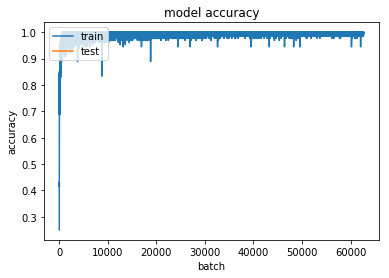

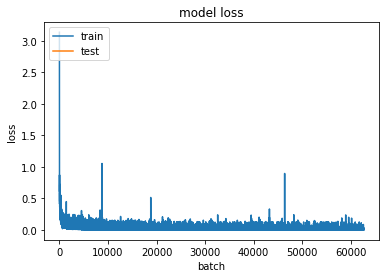

In [10]:

# summarize history for accuracy
plt.plot(lossHistory.acc)
plt.plot(lossHistory.val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(lossHistory.losses)
plt.plot(lossHistory.val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

scores = model.evaluate(X_Ftest, y_Ftest_ohe, verbose=0)

In [11]:
scores

[0.025966466402658286, 0.99545224861040926]

expected: 1.0
prediction:1


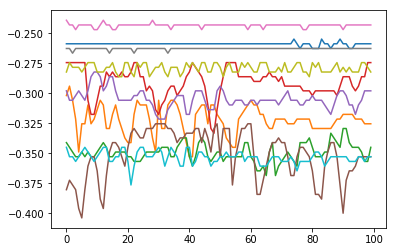

expected: 0.0
prediction:0


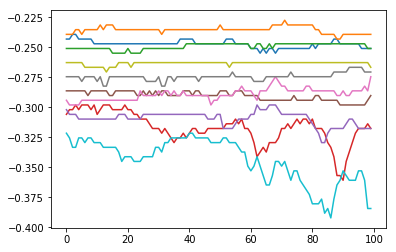

expected: 0.0
prediction:0


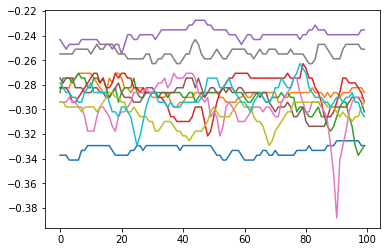

expected: 0.0
prediction:0


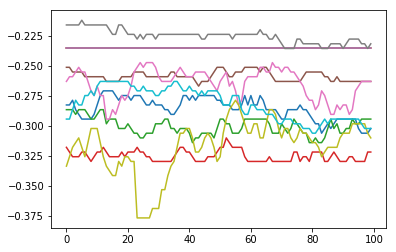

expected: 1.0
prediction:1


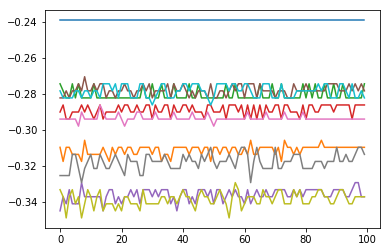

expected: 1.0
prediction:1


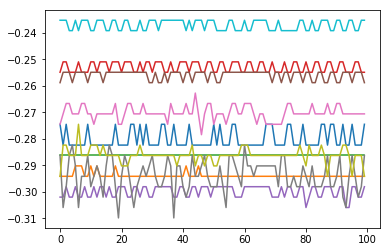

expected: 0.0
prediction:0


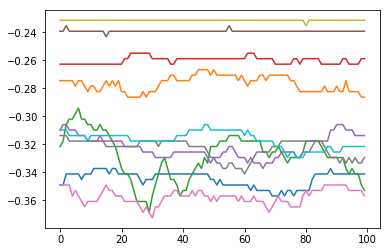

expected: 1.0
prediction:1


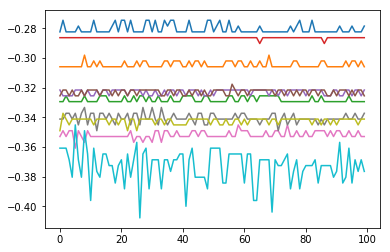

expected: 1.0
prediction:1


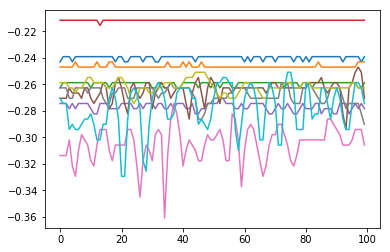

expected: 0.0
prediction:0


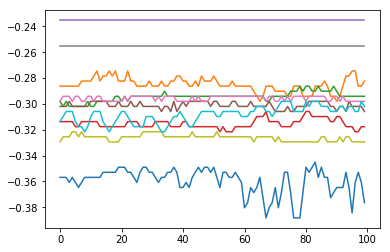

In [12]:

for index in range(10):
    print("expected: "+str( y_Ftest[index]))
    prediction = model.predict(np.expand_dims(X_Ftest[index], axis=0))[0]
    print("prediction:" + str(np.argmax(prediction,axis = 0)))
    time_series = X_Ftest.reshape(X_Ftest.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT) \
        .astype('float32')[index]
    # plt.imshow( X_train.reshape(X_train.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT).astype('float32')[0]);
    # plt.colorbar()
    # plt.show()
    plt.plot(time_series.T[0])
    plt.plot(time_series.T[1])
    plt.plot(time_series.T[2])
    plt.plot(time_series.T[3])
    plt.plot(time_series.T[4])
    plt.plot(time_series.T[5])
    plt.plot(time_series.T[6])
    plt.plot(time_series.T[7])
    plt.plot(time_series.T[8])
    plt.plot(time_series.T[9])
    plt.show()
   

In [13]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# datagen = ImageDataGenerator(
#        vertical_flip=False,
#         horizontal_flip=True)

# index = 0
# time_series = X_test.reshape(X_test.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT) \
#         .astype('float32')[index]

# # plt.plot(time_series.T[0])
# # plt.show()    
# # plt.plot(time_series.T[1])
# # plt.show()    
# # plt.plot(time_series.T[2])
# # plt.show()    
# # plt.plot(time_series.T[3])
# # plt.show()    
# # plt.plot(time_series.T[4])
# # plt.show()    
# # plt.plot(time_series.T[5])
# # plt.show()    
# # print("+++++++++++++++++++++++++++++++++++++++++++++")    
    
    
# # img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
# # x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# # x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
# x = time_series.reshape((1,)+time_series.shape + (1,))
# print("x.shape  ")
# print(x.shape)
# # the .flow() command below generates batches of randomly transformed images
# # and saves the results to the `preview/` directory
# i = 0
# for batch in datagen.flow(x, batch_size=1):
#     i += 1
#     time_series = batch[0]
#     time_series = time_series.reshape( MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT) \
#         .astype('float32')
#     plt.plot(time_series.T[0])
#     plt.plot(time_series.T[1])
#     plt.plot(time_series.T[2])
#     plt.plot(time_series.T[3])
#     plt.plot(time_series.T[4])
#     plt.plot(time_series.T[5])
#     plt.show()
# #     plt.plot(time_series.T[0])
# #     plt.show()    
# #     plt.plot(time_series.T[1])
# #     plt.show()    
# #     plt.plot(time_series.T[2])
# #     plt.show()    
# #     plt.plot(time_series.T[3])
# #     plt.show()    
# #     plt.plot(time_series.T[4])
# #     plt.show()    
# #     plt.plot(time_series.T[5])
# #     plt.show()    
# #     print("+++++++++++++++++++++++++++++++++++++++++++++")    
    
#     if i > 3:
#         break  # otherwise the generator would loop indefinitely